In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

import seaborn as sns
from osgeo import gdal
import numpy.ma as ma
import geopandas as gpd
import rasterio as rio
import shapely
import os
import shutil, os
from rasterio.plot import show
from rasterio.warp import calculate_default_transform, reproject, Resampling

sns.set(font_scale=1.35, style='whitegrid')
%config Completer.use_jedi = False

In [3]:
pwd

'/Users/lamaelhalabi/Documents/research Berekely /Lamas processing code/Maps/My Data'

In [4]:

Shape_file_path_California = '/Users/lamaelhalabi/Documents/research Berekely /Lamas processing code/Maps/My Data'


Reprojection Function
Running gdal.Info() above on the sample ASO and PRISM file shows us that the PRISM data and ASO are in different coordinate systems. This is why the x-ticks and y-ticks for the two datasets were different when plotted above using rasterio.plot.show

Before we can compare the two datasets, we need to ensure that the coordinate systems are consistent. The PRISM data are in a geographic coordinate system, while the ASO data are in a projected coordinate system. A quick google search is the best way to understand the difference (e.g., https://www.esri.com/arcgis-blog/products/arcgis-pro/mapping/gcs_vs_pcs/)

Commonly used coordinate systems have an "EPSG" code associated with them (https://en.wikipedia.org/wiki/EPSG_Geodetic_Parameter_Dataset). The EPSG code corresponding to the PRISM data is EPSG:4269.

In [19]:
def reproject_raster(src_file, dst_file, dst_crs = 'EPSG:4269'): 
    """Reproject the src_file to a coordinate system specified by dst_crs.
    The result in stored in dst_file. EPSG:4269 corresponds to the coordinate
    system employed by PRISM.
    Source: https://rasterio.readthedocs.io/en/latest/topics/reproject.html"""
    
    """calculate_default_transform(): transforms bounds to target coordinate system, calculates resolution if 
    not provided, and returns destination transform and dimensions."""

    with rio.open(src_file) as src:
        transform, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds)
        kwargs = src.meta.copy()   #here we are changing the metadata of src to match 
        kwargs.update({
            'crs': dst_crs,
            'transform': transform,
            'width': width,
            'height': height
        })

        with rio.open(dst_file, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1): #for all 'pixels' in src_file ?
                reproject(
                    source=rio.band(src, i),
                    destination=rio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.nearest)
    return

4. Aggregatation Functions
The ASO data are at 50-meter resolution. The PRISM data are originally at 800-meter resolution. I have downscaled the PRISM data to resolutions of 400-meter and 200-meter using an as-yet unpublished methodology. Downscaling to finer resolutions is not yet possible. To faciliate comparison between ASO and PRISM, the ASO data need to be upscaled from 50-meter to 200-meter, 400-meter and 800-meter.

The following functions help achieve this.

In [20]:
def aggregate2x2(src_array):
    """This function upscales src_array by a factor of 2. Specifically, it uses a 2x2 kernel
    (with a stride of 2) and average pools the src_array.
    """
    src_array = make_shape_even(src_array) # what is this for? 
    #a.shape = np.shape(a) = size of a (here why are we using indexing 1 and 0, arrange = arranges things in order 
    agg_list = [[np.mean(src_array[row:row+2, col:col+2]) for col in np.arange(0,src_array.shape[1],2)] for row in np.arange(0,src_array.shape[0],2)]
    # here we are getting a list of the values of the mean values of 4 pixels to put to one 
    #np.array creates array out of list
    agg_array = np.array(agg_list).reshape(src_array.shape[0]//2,src_array.shape[1]//2) #deviding the size 
    return np.asarray(agg_array, dtype=src_array.dtype)


def make_shape_even(src_array):
    """This function ensures that the shape of a masked array is divisible 2. 
    If not divisible by 2, this functions pads the borders with nan."""
    rows = src_array.shape[0]
    cols = src_array.shape[1]
    rows_dest = rows+1 if rows%2==1 else rows
    cols_dest = cols+1 if cols%2==1 else cols
    dst_array = np.empty((rows_dest,cols_dest))
    dst_array[:] = np.nan
    dst_array[:rows,:cols] = src_array.copy()
    return np.asarray(dst_array, dtype=src_array.dtype)

5. Function to save aggregated array
After aggregating, copy the meta information from the source file, and update the transform.

In [21]:
def write_agg_geotif(template, agg_array, dst_filename):
    """Write the aggregated dataset. This assumes that the
    aggregated dataset upscales src by a factor of 2. For other
    factors, replace '2' by the actual factor."""

    transform = template.transform * template.transform.scale(2,2)
    width = int(np.ceil(template.width/2))
    height = int(np.ceil(template.height/2))
    kwargs = template.meta.copy()
    kwargs.update({
        'transform': transform,
        'width': width,
        'height': height
    })


    with rio.open(dst_filename, "w", **kwargs) as dest:
        dest.write(agg_array,1)
        dest.nodata = template.read(1, masked=True).fill_value
    
    return

Rescale PRISM and ASO grids
Even when ASO and PRISM datasets have the same resolution (e.g., 800M), the pixel sizes are not exactly the same. A usage of gdal.Info() reveals that the ASO 800M dataset has a pixel size of 0.0084 degrees, while the PRISM 800M dataset has a pixel size of 0.0083 degrees. For comparing the two datasets, it is desirable to ensure that the two sets of pixels are exactly the same

In [22]:
def rescale_src_from_template(template_file, src_file, dst_file):
    """This function rescales the src_file raster to the resolution of the template_file raster.
    The rescaled src_file is stored in dst_file raster."""
    template = rio.open(template_file)
    src = rio.open(src_file)

    scale_factor = template.res[0]/src.res[0]

    src_transform = src.transform

    dst_transform = src.transform * src.transform.scale(scale_factor,scale_factor)
    height = int(src.meta['height']/scale_factor)
    width = int(src.meta['width']/scale_factor)

    data = src.read()

    kwargs = src.meta.copy()
    kwargs['transform'] = dst_transform
    kwargs['height'] = height
    kwargs['width'] = width
    kwargs['crs'] = template.crs
    src.close()


    with rio.open(dst_file, 'w', **kwargs) as dst:

        for i, band in enumerate(data, 1):
            dest = np.zeros((height, width), dtype=band.dtype)

            reproject(
                band,
                dest,
                src_transform=src_transform,
                src_crs=template.crs,
                src_nodata=-9999,
                dst_transform=dst_transform,
                dst_crs=template.crs,
                resampling=Resampling.bilinear)

            dst.write(dest, indexes=i)
    return

7. Align PRISM and ASO grids

A careful visual inspection reveals that although the PRISM and ASO pixel sizes are now identical, the grids are still not aligned. E.g., see plot below

In [23]:
def get_Points_gdf(src_file):
    """This function reads in a raster, and obtains Long/Lat values of the center
    of each pixel. It returns a geodataframe."""
    raster = rio.open(src_file)
    arr = raster.read(1)
    indices = np.argwhere(~np.isnan(arr))

    coords = raster.xy(indices[:,0], indices[:,1])

    Points_gdf= gpd.GeoDataFrame({'Longitude':coords[0],'Latitude': coords[1]},
                                  geometry=[shapely.geometry.Point(x, y) for x, y in zip(coords[0], coords[1])])
    return Points_gdf



def translate_rescaled_src(template_file, src_file, rescaled_src_file, Points_gdf, dst_file):
    """This function rescales and translates the src_file raster so that the grid is perfectly
    aligned with the template_file raster grid. It uses the rescaled_src_file to determine how much 
    translation is needed."""
    
    template = rio.open(template_file)
    rescaled_src = rio.open(rescaled_src_file)

    rc = rio.transform.rowcol(rescaled_src.transform, Points_gdf.Longitude[0], Points_gdf.Latitude[0])
    cr_coord = [item + 0.5 for item in reversed(rc)]

    pixel_coord = ~rescaled_src.transform*(Points_gdf.Longitude[0], Points_gdf.Latitude[0])
    pixel_coord = list(pixel_coord)

    offset_x = pixel_coord[0] - cr_coord[0]
    offset_y = pixel_coord[1] - cr_coord[1]



    with rio.open(src_file) as src:
        
        scale_factor = template.res[0]/src.res[0]
        
        src_transform = src.transform

        dst_transform = src.transform * src.transform.scale(scale_factor,scale_factor) * src.transform.translation(offset_x,offset_y)

        height = int(src.meta['height']/scale_factor)
        width = int(src.meta['width']/scale_factor)

        data = src.read()

        kwargs = src.meta.copy()
        kwargs['transform'] = dst_transform
        kwargs['height'] = height
        kwargs['width'] = width
        kwargs['crs'] = template.crs



        with rio.open(dst_file, 'w', **kwargs) as dst:

            for i, band in enumerate(data, 1):
                dest = np.zeros((height, width), dtype=band.dtype)

                reproject(
                    band,
                    dest,
                    src_transform=src_transform,
                    src_crs=template.crs,
                    src_nodata=-9999,
                    dst_transform=dst_transform,
                    dst_crs=template.crs,
                    resampling=Resampling.bilinear)

                dst.write(dest, indexes=i)
        
    return

In [49]:
data_path = "/Users/lamaelhalabi/Documents/research Berekely /Lamas processing code/Maps"
data_dir = os.listdir(data_path)
# for each folder in the directory
ASO_files = [] #create an empty list of ASO files 

for s in data_dir:  #remove the .xml files
    if '.xml' not in s and 'ASO' in s and '.tif' in s:
        ASO_files.append(s)

ASO_files = sorted(ASO_files) #remove duplicate spatial extents  
print(ASO_files)

['ASO_50M_SWE_USCACE_20160401.tif', 'ASO_50M_SWE_USCACE_20160407.tif', 'ASO_50M_SWE_USCACE_20160416.tif', 'ASO_50M_SWE_USCACE_20160426.tif', 'ASO_50M_SWE_USCACE_20160509.tif', 'ASO_50M_SWE_USCACE_20170129.tif', 'ASO_50M_SWE_USCACE_20170717.tif', 'ASO_50M_SWE_USCACE_20170727.tif', 'ASO_50M_SWE_USCACE_20170816.tif', 'ASO_50M_SWE_USCACE_20180423.tif', 'ASO_50M_SWE_USCACE_20180528.tif', 'ASO_50M_SWE_USCAJW_20180423.tif', 'ASO_50M_SWE_USCAJW_20180602.tif', 'ASO_50M_SWE_USCAJW_20190315.tif', 'ASO_50M_SWE_USCAJW_20190605.tif', 'ASO_50M_SWE_USCAKC_20180426.tif', 'ASO_50M_SWE_USCAKC_20190316.tif', 'ASO_50M_SWE_USCAKC_20190326.tif', 'ASO_50M_SWE_USCAKC_20190418.tif', 'ASO_50M_SWE_USCAKC_20190427.tif', 'ASO_50M_SWE_USCAKC_20190428.tif', 'ASO_50M_SWE_USCAKC_20190608.tif', 'ASO_50M_SWE_USCAKC_20190611.tif', 'ASO_50M_SWE_USCAKN_20180426.tif', 'ASO_50M_SWE_USCAKN_20190417.tif', 'ASO_50M_SWE_USCAKW_20190317.tif', 'ASO_50M_SWE_USCAKW_20190324.tif', 'ASO_50M_SWE_USCAKW_20190421.tif', 'ASO_50M_SWE_USCALB

In [50]:
for file in ASO_files:
    shutil.move(file, '/Users/lamaelhalabi/Documents/research Berekely /Lamas processing code/Maps/My Data')

In [51]:
cd '/Users/lamaelhalabi/Documents/research Berekely /Lamas processing code/Maps/My Data'

/Users/lamaelhalabi/Documents/research Berekely /Lamas processing code/Maps/My Data


This code is to reproject and aggregate all ASO files creating 5 Reprojected files at resolution 50M, 100M, 200M, 400M, 800M

In [52]:
for ASO_file in ASO_files:
        
    # reproject ASO file
    ASO_file_reprojected = '50MReprojected' + ASO_file
    desired_crs = 'epsg:4269'
    reproject_raster(ASO_file, ASO_file_reprojected, desired_crs)
        
    #aggregate (4-5)
    dst_filename = '100' + ASO_file_reprojected[2 :]
    
    for i in range(4):
        src_raster = rio.open(ASO_file_reprojected)
        agg_array = aggregate2x2(src_raster.read(1, masked=True).filled(fill_value=np.nan))
        ASO_file_reprojected = dst_filename 
        write_agg_geotif(src_raster, agg_array, dst_filename)
        src_raster.close()
        if i == 0:
            dst_filename = '200' + dst_filename[3 :]
        if i == 1:
            dst_filename = '400' + dst_filename[3 :]
        if i == 2:
            dst_filename = '800' + dst_filename[3 :]
        

In [53]:
data_path = "/Users/lamaelhalabi/Documents/research Berekely /Lamas processing code/Maps/My Data"
data_dir = os.listdir(data_path)
# for each folder in the directory
ASO_files_50M = [] #create an empty list of ASO files 
ASO_files_100M = []
ASO_files_200M = []
ASO_files_400M = []
ASO_files_800M = []

for s in data_dir:  #remove the .xml files
    
    if '50MReprojected' in s and '.tif' in s:
        ASO_files_50M.append(s)
        
    if '100MReprojected' in s and '.tif' in s:
        ASO_files_100M.append(s)
    
    if '200MReprojected' in s and '.tif' in s:
        ASO_files_200M.append(s)
    
    if '400MReprojected' in s and '.tif' in s:
        ASO_files_400M.append(s)
    
    if '800MReprojected' in s and '.tif' in s:
        ASO_files_800M.append(s)
        
print(ASO_files_50M)
print(ASO_files_100M)
print(ASO_files_200M)

['50MReprojectedASO_50M_SWE_USCAJW_20190315.tif', '50MReprojectedASO_50M_SWE_USCASJ_20170719.tif', '50MReprojectedASO_50M_SWE_USCAKC_20190608.tif', '50MReprojectedASO_50M_SWE_USCAKC_20180426.tif', '50MReprojectedASO_50M_SWE_USCATB_20160407.tif', '50MReprojectedASO_50M_SWE_USCASF_20190317.tif', '50MReprojectedASO_50M_SWE_USCAMB_20190604.tif', '50MReprojectedASO_50M_SWE_USCATB_20130608.tif', '50MReprojectedASO_50M_SWE_USCACE_20160426.tif', '50MReprojectedASO_50M_SWE_USCAKW_20190324.tif', '50MReprojectedASO_50M_SWE_USCASJ_20180601.tif', '50MReprojectedASO_50M_SWE_USCATE_20190324.tif', '50MReprojectedASO_50M_SWE_USCASF_20190704.tif', '50MReprojectedASO_50M_SWE_USCASF_20190714.tif', '50MReprojectedASO_50M_SWE_USCALB_20170128.tif', '50MReprojectedASO_50M_SWE_USCASF_20190502.tif', '50MReprojectedASO_50M_SWE_USCALB_20180422.tif', '50MReprojectedASO_50M_SWE_USCASJ_20190614.tif', '50MReprojectedASO_50M_SWE_USCAKC_20190418.tif', '50MReprojectedASO_50M_SWE_USCATB_20160401.tif', '50MReprojectedASO_

In [54]:
for file in ASO_files_50M:
    shutil.move(file, '/Users/lamaelhalabi/Documents/research Berekely /Lamas processing code/Maps/My Data/50M')
    
for file in ASO_files_100M:
    shutil.move(file, '/Users/lamaelhalabi/Documents/research Berekely /Lamas processing code/Maps/My Data/100M')
    
for file in ASO_files_200M:
    shutil.move(file, '/Users/lamaelhalabi/Documents/research Berekely /Lamas processing code/Maps/My Data/200M')

for file in ASO_files_400M:
    shutil.move(file, '/Users/lamaelhalabi/Documents/research Berekely /Lamas processing code/Maps/My Data/400M')
    
for file in ASO_files_800M:
    shutil.move(file, '/Users/lamaelhalabi/Documents/research Berekely /Lamas processing code/Maps/My Data/800M')

Rescaling depends on resolution, for that reason I segregated ASO files in terms of resolution. 

In [55]:
PRISM_file_200M = 'DOWNSCALED_PRISM_TAVG_20190122.tif'
PRISM_file_400M = 'DOWNSCALED_PRISM_PPT_20190108.tif'
PRISM_file_800M ='PRISM_PPT_20190108.tif'

In [59]:
cd '/Users/lamaelhalabi/Documents/research Berekely /Lamas processing code/Maps/My Data/800M'

/Users/lamaelhalabi/Documents/research Berekely /Lamas processing code/Maps/My Data/800M


In [65]:

for ASO_file in ASO_files_800M:
    #Rescaling the ASO_file according to the PRISM_file_800M and saving it in the rescaled_ASO_file
    template_file = PRISM_file_800M
    rescaled_ASO_file = 'Rescaled_' + ASO_file
    rescale_src_from_template(PRISM_file_800M, ASO_file, rescaled_ASO_file) 
    
    
    #we are aligning rescaled_ASO_file according to the prism file
    Points_gdf = get_Points_gdf(template_file)
    rescaled_translated_ASO_file = 'Translated_' + rescaled_ASO_file
    translate_rescaled_src(template_file, ASO_file, rescaled_ASO_file, Points_gdf, rescaled_translated_ASO_file)

Plot for 800M 

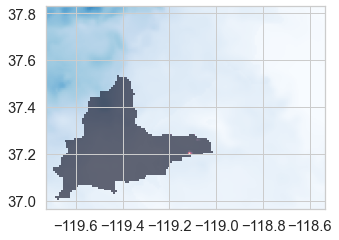

In [71]:
fig, ax = plt.subplots(figsize=(5,5))

with rio.open(PRISM_file_800M) as src:
    show(src.read(1, masked=True), ax=ax, transform=src.transform, cmap = 'Blues')

with rio.open('Translated_Rescaled_800MReprojectedASO_50M_SWE_USCAJW_20180602.tif') as src:
        show(src.read(1, masked=True), ax=ax, transform=src.transform, alpha=0.6)

In [72]:
cd '/Users/lamaelhalabi/Documents/research Berekely /Lamas processing code/Maps/My Data/400M'

/Users/lamaelhalabi/Documents/research Berekely /Lamas processing code/Maps/My Data/400M


In [73]:

for ASO_file in ASO_files_400M:
    #Rescaling the ASO_file according to the PRISM_file_800M and saving it in the rescaled_ASO_file
    template_file = PRISM_file_400M
    rescaled_ASO_file = 'Rescaled_' + ASO_file
    rescale_src_from_template(template_file, ASO_file, rescaled_ASO_file) 
    
    
    #we are aligning rescaled_ASO_file according to the prism file
    Points_gdf = get_Points_gdf(template_file)
    rescaled_translated_ASO_file = 'Translated_' + rescaled_ASO_file
    translate_rescaled_src(template_file, ASO_file, rescaled_ASO_file, Points_gdf, rescaled_translated_ASO_file)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

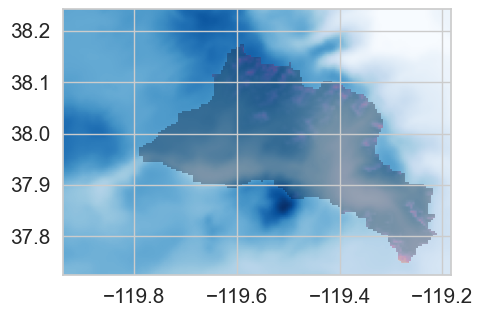

In [82]:
%matplotlib widget
fig, ax = plt.subplots(figsize=(5,5))

with rio.open(PRISM_file_400M) as src:
    show(src.read(1, masked=True), ax=ax, transform=src.transform, cmap = 'Blues')

with rio.open('Translated_Rescaled_400MReprojectedASO_50M_SWE_USCATB_20170717.tif') as src:
        show(src.read(1, masked=True), ax=ax, transform=src.transform, alpha=0.3)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

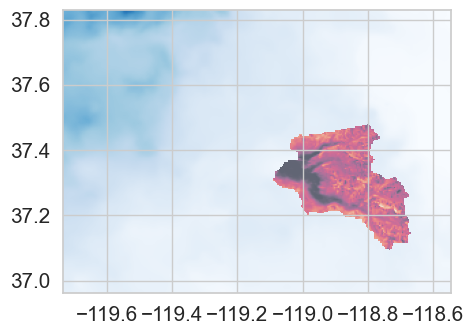

In [81]:
%matplotlib widget

fig, ax = plt.subplots(figsize=(5,5))

with rio.open(PRISM_file_400M) as src:
    show(src.read(1, masked=True), ax=ax, transform=src.transform, cmap = 'Blues')

with rio.open('Translated_Rescaled_400MReprojectedASO_50M_SWE_USCASF_20190317.tif') as src:
        show(src.read(1, masked=True), ax=ax, transform=src.transform, alpha=0.6)

In [84]:
ASO_file = 'Translated_Rescaled_800MReprojectedASO_50M_SWE_USCAKW_20190324.tif'
ASO_date_str = ASO_file.split('_')[6]
ASO_date_str = ASO_date_str[: 8]
print(ASO_date_str)


20190324


In [86]:
cd '/Users/lamaelhalabi/Documents/research Berekely /Lamas processing code/Maps/My Data/200M'

/Users/lamaelhalabi/Documents/research Berekely /Lamas processing code/Maps/My Data/200M


In [ ]:

for ASO_file in ASO_files_200M:
    #Rescaling the ASO_file according to the PRISM_file_800M and saving it in the rescaled_ASO_file
    template_file = PRISM_file_200M
    rescaled_ASO_file = 'Rescaled_' + ASO_file
    rescale_src_from_template(template_file, ASO_file, rescaled_ASO_file) 
    
    
    #we are aligning rescaled_ASO_file according to the prism file
    Points_gdf = get_Points_gdf(template_file)
    rescaled_translated_ASO_file = 'Translated_' + rescaled_ASO_file
    translate_rescaled_src(template_file, ASO_file, rescaled_ASO_file, Points_gdf, rescaled_translated_ASO_file)

In [26]:
cd '/Users/lamaelhalabi/Documents/research Berekely /Lamas processing code/Maps/My Data/800M'

/Users/lamaelhalabi/Documents/research Berekely /Lamas processing code/Maps/My Data/800M


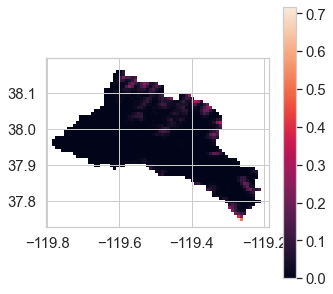

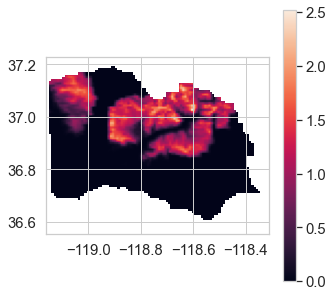

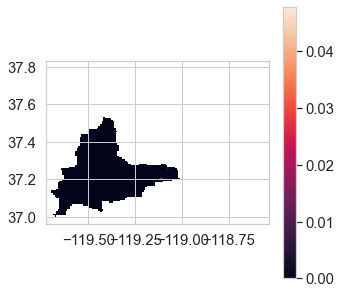

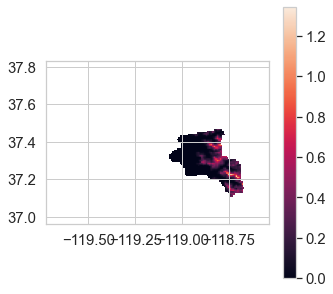

In [10]:
ASO_files = ['Translated_Rescaled_800MReprojectedASO_50M_SWE_USCATB_20130608.tif', 'Translated_Rescaled_800MReprojectedASO_50M_SWE_USCAKC_20190428.tif', 'Translated_Rescaled_800MReprojectedASO_50M_SWE_USCAJW_20180602.tif', 'Translated_Rescaled_800MReprojectedASO_50M_SWE_USCASF_20180601.tif']
for ASO_file in ASO_files:
    with rio.open(ASO_file) as src:
        fig, ax = plt.subplots(figsize=(5,5))
        plt.imshow(src.read(1, masked=True))
        show(src.read(1, masked=True), transform = src.transform, ax=ax)
        plt.colorbar()

Data processing of Topography files : 
1. What are the properties of these files? gdal.info()

In [29]:
cd '/Users/lamaelhalabi/Documents/research Berekely /Lamas processing code/Maps/My Data/Topography'

/Users/lamaelhalabi/Documents/research Berekely /Lamas processing code/Maps/My Data/Topography


In [30]:
PRISM_file_800M ='PRISM_PPT_20191121.tif'
Topography_file = 'Aspect_clipped_800.tif'

In [18]:
gdal.Info(Topography_file).split('\n') 

['Driver: GTiff/GeoTIFF',
 'Files: Aspect_clipped_800.tif',
 'Size is 196, 253',
 'Coordinate System is:',
 'GEOGCRS["NAD83",',
 '    DATUM["North American Datum 1983",',
 '        ELLIPSOID["GRS 1980",6378137,298.257222101004,',
 '            LENGTHUNIT["metre",1]]],',
 '    PRIMEM["Greenwich",0,',
 '        ANGLEUNIT["degree",0.0174532925199433]],',
 '    CS[ellipsoidal,2],',
 '        AXIS["geodetic latitude (Lat)",north,',
 '            ORDER[1],',
 '            ANGLEUNIT["degree",0.0174532925199433]],',
 '        AXIS["geodetic longitude (Lon)",east,',
 '            ORDER[2],',
 '            ANGLEUNIT["degree",0.0174532925199433]],',
 '    ID["EPSG",4269]]',
 'Data axis to CRS axis mapping: 2,1',
 'Origin = (-119.945833333536498,38.245833333799510)',
 'Pixel Size = (0.008333333333000,-0.008333333333000)',
 'Metadata:',
 '  AREA_OR_POINT=Area',
 '  PROCESSING_HISTORY=2021-06-03 03:19:28.291212 UTC | RichDEM (Python 0.3.4) (hash="Unknown", hashdate="Unknown") | LoadGDAL(filename=/Us

Topography files are in the same coordinate system as prism files and are of the same resolution and pixel size-- > no need for reprojection, aggregation, or rescaling. Only alignment 

In [25]:
gdal.Info(PRISM_file_800M).split('\n') 

['Driver: GTiff/GeoTIFF',
 'Files: PRISM_PPT_20191121.tif',
 'Size is 196, 253',
 'Coordinate System is:',
 'GEOGCRS["NAD83",',
 '    DATUM["North American Datum 1983",',
 '        ELLIPSOID["GRS 1980",6378137,298.257222101004,',
 '            LENGTHUNIT["metre",1]]],',
 '    PRIMEM["Greenwich",0,',
 '        ANGLEUNIT["degree",0.0174532925199433]],',
 '    CS[ellipsoidal,2],',
 '        AXIS["geodetic latitude (Lat)",north,',
 '            ORDER[1],',
 '            ANGLEUNIT["degree",0.0174532925199433]],',
 '        AXIS["geodetic longitude (Lon)",east,',
 '            ORDER[2],',
 '            ANGLEUNIT["degree",0.0174532925199433]],',
 '    ID["EPSG",4269]]',
 'Data axis to CRS axis mapping: 2,1',
 'Origin = (-119.945833333536513,38.245833333799503)',
 'Pixel Size = (0.008333333333000,-0.008333333333000)',
 'Metadata:',
 '  AREA_OR_POINT=Area',
 'Image Structure Metadata:',
 '  INTERLEAVE=BAND',
 'Corner Coordinates:',
 'Upper Left  (-119.9458333,  38.2458333) (119d56\'45.00"W, 38d

In [28]:
gdal.Info('Translated_Rescaled_800MReprojectedASO_50M_SWE_USCATB_20130608.tif').split('\n') 

['Driver: GTiff/GeoTIFF',
 'Files: Translated_Rescaled_800MReprojectedASO_50M_SWE_USCATB_20130608.tif',
 'Size is 74, 56',
 'Coordinate System is:',
 'GEOGCRS["NAD83",',
 '    DATUM["North American Datum 1983",',
 '        ELLIPSOID["GRS 1980",6378137,298.257222101004,',
 '            LENGTHUNIT["metre",1]]],',
 '    PRIMEM["Greenwich",0,',
 '        ANGLEUNIT["degree",0.0174532925199433]],',
 '    CS[ellipsoidal,2],',
 '        AXIS["geodetic latitude (Lat)",north,',
 '            ORDER[1],',
 '            ANGLEUNIT["degree",0.0174532925199433]],',
 '        AXIS["geodetic longitude (Lon)",east,',
 '            ORDER[2],',
 '            ANGLEUNIT["degree",0.0174532925199433]],',
 '    ID["EPSG",4269]]',
 'Data axis to CRS axis mapping: 2,1',
 'Origin = (-119.804166666875503,38.195833333801502)',
 'Pixel Size = (0.008333333333000,-0.008333333333000)',
 'Metadata:',
 '  AREA_OR_POINT=Area',
 'Image Structure Metadata:',
 '  INTERLEAVE=BAND',
 'Corner Coordinates:',
 'Upper Left  (-119.8

In [31]:
files = ['Aspect_clipped_800.tif', 'DEM_clipped_800.tif', 'Slope_clipped_800.tif']
template_file = PRISM_file_800M
for file in files:
    #we are aligning file according to the prism file
    Points_gdf = get_Points_gdf(template_file)
    translated_topography_file = 'Translated_' + file
    translate_rescaled_src(template_file, file, file, Points_gdf, translated_topography_file)

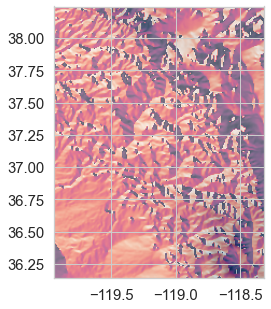

In [32]:
fig, ax = plt.subplots(figsize=(5,5))

with rio.open(PRISM_file_800M) as src:
    show(src.read(1, masked=True), ax=ax, transform=src.transform, cmap = 'Blues')

with rio.open('Translated_Aspect_clipped_800.tif') as src:
        show(src.read(1, masked=True), ax=ax, transform=src.transform, alpha=0.6)